In [1]:
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm_notebook
import plotly.graph_objects as go
from numpyro.infer.initialization import init_to_value
import sklearn.metrics as metrics
from jax.nn import softmax
from sklearn.preprocessing import LabelBinarizer
from jax import ops
from jax.experimental import loops
import jax

numpyro.util.set_rng_seed(0)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [2]:
# Create folder for storing results

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
new_dir = os.path.join("../../output/multi_class/", "numpyro_c_" + time)
os.mkdir(new_dir)

In [3]:
print(new_dir)

../../output/multi_class/numpyro_c_2021_05_13_11_28_25


In [4]:
ITER = 100000
CHAINS = 4

In [5]:
def load_data():

    # Load Data

    df = pd.read_table("../../data/cdata", header=None, delim_whitespace=True)
    df.columns = ["X1", "X2", "X3", "X4", "Y"]
    df["index"] = np.where(df.index < 400, "Train", "Test")

    # Create train and test

    X_train = np.array(df.loc[df["index"] == "Train", ["X1", "X2", "X3", "X4"]]).reshape(-1, 4)
    Y_train = np.array(df.loc[df["index"] == "Train", "Y"])
    X_test = np.array(df.loc[df["index"] == "Test", ["X1", "X2", "X3", "X4"]]).reshape(-1, 4)
    Y_test = np.array(df.loc[df["index"] == "Test", "Y"])

    return X_train, X_test, Y_train, Y_test

In [6]:
X_train, X_test, Y_train, Y_test = load_data()

In [7]:
# One hot encode Y_train to align with dist.Multinomial()

Y_train_ohe = LabelBinarizer().fit_transform(Y_train)

In [8]:
def model(x, y):
    
    # ARD Hyperparameters for inputs 
    
    w_ih_prec = numpyro.sample("w_ih_prec", dist.Gamma(0.25, 0.000625))
    w_ih_prec_1 = numpyro.sample("w_ih_prec_1", dist.Gamma(0.5, 0.5*(1/w_ih_prec)))
    w_ih_prec_2 = numpyro.sample("w_ih_prec_2", dist.Gamma(0.5, 0.5*(1/w_ih_prec)))
    w_ih_prec_3 = numpyro.sample("w_ih_prec_3", dist.Gamma(0.5, 0.5*(1/w_ih_prec)))
    w_ih_prec_4 = numpyro.sample("w_ih_prec_4", dist.Gamma(0.5, 0.5*(1/w_ih_prec)))
    
    # Hyperparameters for ho weights and biases
    
    b_h_prec = numpyro.sample("b_h_prec", dist.Gamma(0.25, 0.000625))
    w_ho_prec = numpyro.sample("w_ho_prec", dist.Gamma(0.25, 7.8125e-05))
    b_o_prec = numpyro.sample("b_o_prec", dist.Gamma(0.25, 0.000625))
    
    # Input weight-matrix
    
    w_ih_1 = numpyro.sample("w_ih_1", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(w_ih_prec_1)))
    w_ih_2 = numpyro.sample("w_ih_2", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(w_ih_prec_2)))
    w_ih_3 = numpyro.sample("w_ih_3", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(w_ih_prec_3)))
    w_ih_4 = numpyro.sample("w_ih_4", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(w_ih_prec_4)))
    
    # Low Level Parameters

    b_h = numpyro.sample("b_h", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(b_h_prec)))
    w_ho = numpyro.sample("w_ho", dist.Normal(loc=jnp.zeros((8, 3)), scale=1/jnp.sqrt(w_ho_prec)))
    b_o = numpyro.sample("b_o", dist.Normal(loc=jnp.zeros((1, 3)), scale=1/jnp.sqrt(b_o_prec)))
    
    # Forward Pass
    
    w_ih = jnp.stack([w_ih_1, w_ih_2, w_ih_3, w_ih_4], axis=1).reshape(4, 8)
    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    output_sm = softmax(output)
    
    return numpyro.sample("y_pred", dist.Multinomial(total_count=1, probs=output_sm), obs=y)

In [9]:
# import torch.distributions
# a = torch.distributions.Multinomial(total_count=1, probs=torch.tensor([0.3, 0.3, 0.4]))
# a.sample()

In [10]:
init_values = {
    
    "w_ih_prec": 1.,
    "w_ih_prec_1": 1.,
    "w_ih_prec_2": 1.,
    "w_ih_prec_3": 1.,
    "w_ih_prec_4": 1.,
    "b_h_prec": 1.,
    "w_ho_prec": 1.,
    "w_ih_1": jnp.zeros((1, 8)),
    "w_ih_2": jnp.zeros((1, 8)),
    "w_ih_3": jnp.zeros((1, 8)),
    "w_ih_4": jnp.zeros((1, 8)),
    "b_h": jnp.zeros((1, 8)),
    "w_ho": jnp.zeros((8, 3)),
    "b_o": jnp.zeros((1, 3))

}

In [11]:
rng_key = random.PRNGKey(42)
rng_key, rng_key_predict = random.split(rng_key)

nuts_kernel = NUTS(model, 
                   adapt_mass_matrix=False, 
                   init_strategy = init_to_value(values=init_values))

mcmc = MCMC(nuts_kernel,
            num_samples=ITER,
            num_warmup=1000,
            num_chains=4,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)

mcmc.run(rng_key,
         jnp.array(X_train.reshape((len(Y_train), 4))), 
         jnp.array(Y_train_ohe.reshape((len(Y_train), 3))))

mcmc.print_summary()

samples = mcmc.get_samples()






                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     b_h[0,0]     -0.02      2.37      0.04     -3.38      3.39  26937.63      1.00
     b_h[0,1]     -0.27      2.40     -0.55     -3.40      3.34    132.73      1.02
     b_h[0,2]     -0.11      2.38     -0.32     -3.40      3.39  11522.57      1.00
     b_h[0,3]      0.05      2.41      0.16     -3.43      3.39  16972.27      1.00
     b_h[0,4]      0.11      2.41      0.28     -3.37      3.38    813.05      1.01
     b_h[0,5]     -0.08      2.42     -0.17     -3.41      3.36  15928.33      1.00
     b_h[0,6]      0.10      2.41      0.23     -3.41      3.37    209.15      1.02
     b_h[0,7]      0.28      2.47      0.68     -3.43      3.39    178.88      1.02
     b_h_prec      0.71      1.60      0.40      0.00      1.57    148.17      1.02
     b_o[0,0]     -0.37      3.35     -0.01     -1.08      0.87   2403.40      1.00
     b_o[0,1]     -0.13      2.93     -0.00     -0.99      0.87   2756.

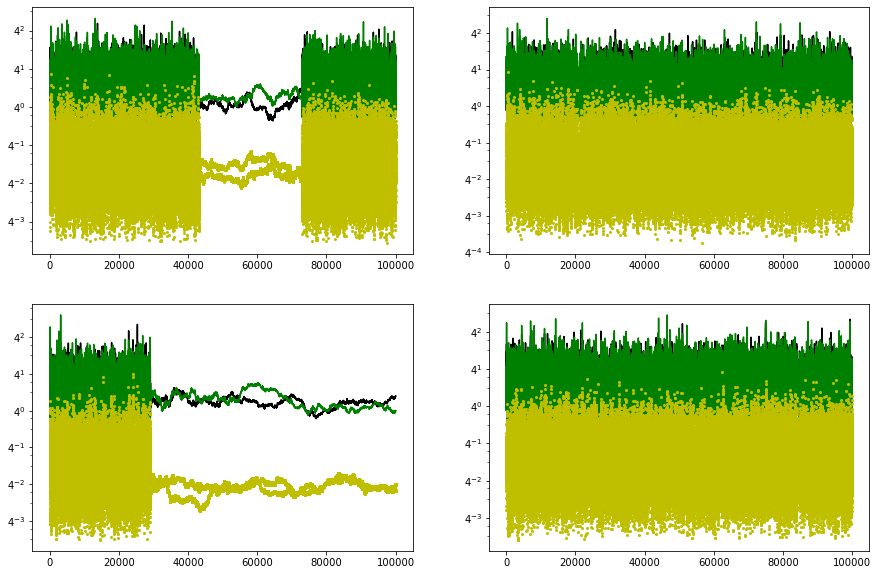

In [12]:
plt.figure(figsize = (15,10))
BASE = 4

plt.subplot(2, 2, 1)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][1:(ITER)]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][1:(ITER)]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][1:(ITER)]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][1:(ITER)]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][ITER:2*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][ITER:2*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][ITER:2*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][ITER:2*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 3)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][2*ITER:3*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][2*ITER:3*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][2*ITER:3*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][2*ITER:3*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

plt.subplot(2, 2, 4)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_1"][3*ITER:4*ITER]), "k-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_2"][3*ITER:4*ITER]), "g-", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_3"][3*ITER:4*ITER]), "yo", markersize=2)
plt.plot(1/jnp.sqrt(samples["w_ih_prec_4"][3*ITER:4*ITER]), "yo", markersize=2)
plt.yscale('log',basey=BASE) 

In [13]:
# TODO: can we make this more like tf_probability? The vmap function speeds it up.

# def predict(model, rng_key, samples, X):
    
#     model = handlers.substitute(handlers.seed(model, rng_key), samples)
    
#     # note that Y will be sampled in the model because we pass Y=None here
    
#     model_trace = handlers.trace(model).get_trace(x=X, y=None)
    
#     return model_trace['output']['value']

In [14]:
def prob_prediction(x, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o):
    
    w_ih = jnp.stack([w_ih_1, w_ih_2, w_ih_3, w_ih_4], axis=1).reshape(4, 8)
    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    
    return softmax(output)

In [15]:
samples['b_h'].shape

(400000, 1, 8)

In [16]:
with loops.Scope() as s:

    s.train_predictions = np.zeros((ITER * CHAINS, X_train.shape[0], 3))
    s.test_predictions = np.zeros((ITER * CHAINS, X_test.shape[0], 3))
    
    for i in s.range(0, len(samples["w_ih_1"])):

        w_ih_1 = samples["w_ih_1"][i]
        w_ih_2 = samples["w_ih_2"][i]
        w_ih_3 = samples["w_ih_3"][i]
        w_ih_4 = samples["w_ih_4"][i]
        b_h = samples["b_h"][i]
        w_ho = samples["w_ho"][i]
        b_o = samples["b_o"][i]

        s.train_predictions = ops.index_update(s.train_predictions, jax.ops.index[i, :] ,
                                               prob_prediction(X_train, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o).reshape(
                                                   X_train.shape[0], 3))
        
        s.test_predictions = ops.index_update(s.test_predictions, jax.ops.index[i, :] ,
                                               prob_prediction(X_test, w_ih_1, w_ih_2, w_ih_3, w_ih_4, b_h, w_ho, b_o).reshape(
                                                   X_test.shape[0], 3))

In [17]:
# train_predictions = np.zeros((ITER * CHAINS, X_train.shape[0], 3))

# for i in range(0, len(samples["w_ih_1"])):

#     w_ih_1 = samples["w_ih_1"][i]
#     w_ih_2 = samples["w_ih_2"][i]
#     w_ih_3 = samples["w_ih_3"][i]
#     w_ih_4 = samples["w_ih_4"][i]
#     b_h = samples["b_h"][i]
#     w_ho = samples["w_ho"][i]
#     b_o = samples["b_o"][i]

#     train_predictions[i, :] = prob_prediction(X_train, w_ih_1, w_ih_2, w_ih_3, w_ih_4,  
#                                               b_h, w_ho, b_o).reshape(X_train.shape[0], 3)

# test_predictions = np.zeros((ITER * CHAINS, X_test.shape[0], 3))

# for i in range(0, len(samples["w_ih_1"])):
    
#     w_ih_1 = samples["w_ih_1"][i]
#     w_ih_2 = samples["w_ih_2"][i]
#     w_ih_3 = samples["w_ih_3"][i]
#     w_ih_4 = samples["w_ih_4"][i]
#     b_h = samples["b_h"][i]
#     w_ho = samples["w_ho"][i]
#     b_o = samples["b_o"][i]
    
#     test_predictions[i, :] = prob_prediction(X_test, w_ih_1, w_ih_2, w_ih_3, w_ih_4, 
#                                              b_h, w_ho, b_o).reshape(X_test.shape[0], 3)

In [18]:
# Train and Test Predictions

# vmap_args = (samples, random.split(rng_key_predict, ITER * CHAINS))
# train_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_train))(*vmap_args)
# test_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test))(*vmap_args)

# Re-assign probability predictions

y_train_pred = s.train_predictions
y_test_pred = s.test_predictions
train_mean_probs = y_train_pred.mean(axis=0)
test_mean_probs = y_test_pred.mean(axis=0)

In [19]:
s.train_predictions.shape

(400000, 400, 3)

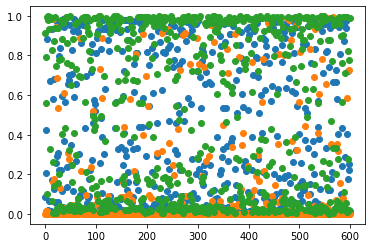

In [20]:
plt.plot(y_test_pred[994, :, :], "o");

In [21]:
train_mean_probs[:, 0].flatten().shape

(400,)

In [22]:
np.argmax(train_mean_probs, axis=1).reshape(len(Y_train), 1).shape

(400, 1)

In [23]:
# Train and Test Predictions

df_predictions_train = pd.DataFrame({
    
    "X_V1": X_train[:, 0].flatten(),
    "X_V2": X_train[:, 1].flatten(),
    "X_V3": X_train[:, 2].flatten(),
    "X_V4": X_train[:, 3].flatten(),
    "targets": Y_train.flatten(),
    "predicted": np.argmax(train_mean_probs, axis=1),
    "mean_prob_1": train_mean_probs[:, 0].flatten(),
    "mean_prob_2": train_mean_probs[:, 1].flatten(),
    "mean_prob_3": train_mean_probs[:, 2].flatten(),
    "label": "train"
})

df_predictions_test = pd.DataFrame({
    
    "X_V1": X_test[:, 0].flatten(),
    "X_V2": X_test[:, 1].flatten(),
    "X_V3": X_test[:, 2].flatten(),
    "X_V4": X_test[:, 3].flatten(),
    "targets": Y_test.flatten(),
    "predicted": np.argmax(test_mean_probs, axis=1),
    "mean_prob_1": test_mean_probs[:, 0].flatten(),
    "mean_prob_2": test_mean_probs[:, 1].flatten(),
    "mean_prob_3": test_mean_probs[:, 2].flatten(),
    "label": "test"

})

In [24]:
error = (df_predictions_test.targets - df_predictions_test.predicted).abs()
error[error > 1] = 1
error.sum()/len(error)*100

14.000000000000002

In [25]:
# Low-level parameters

df_wih_1 = pd.DataFrame(samples['w_ih_1'].reshape(ITER*CHAINS, 8))
df_wih_2 = pd.DataFrame(samples['w_ih_2'].reshape(ITER*CHAINS, 8))
df_wih_3 = pd.DataFrame(samples['w_ih_3'].reshape(ITER*CHAINS, 8))
df_wih_4 = pd.DataFrame(samples['w_ih_4'].reshape(ITER*CHAINS, 8))
df_bh = pd.DataFrame(samples['b_h'].reshape(ITER*CHAINS, 8))
df_who = pd.DataFrame(samples['w_ho'].reshape(ITER*CHAINS, 24))
df_bo = pd.DataFrame(samples['b_o'].reshape(ITER*CHAINS, 3))

# Rename columns

df_wih_1.columns = ["w_ih_1_" + str(i) for i in range(0, 8)]
df_wih_2.columns = ["w_ih_2_" + str(i) for i in range(0, 8)]
df_wih_3.columns = ["w_ih_3_" + str(i) for i in range(0, 8)]
df_wih_4.columns = ["w_ih_4_" + str(i) for i in range(0, 8)]
df_bh.columns = ["b_h_" + str(i) for i in range(0, 8)]
df_who.columns = ["w_ho_" + str(i) for i in range(0, 24)]
df_bo.columns = ["b_o_" + str(i) for i in range(0, 3)]

df_traces = pd.concat([df_wih_1, df_wih_2, df_wih_3, df_wih_4, 
                       df_bh, df_who, df_bo], ignore_index=False, axis=1)

# High level parameters

df_traces["W_prec_ih"] = samples['w_ih_prec'].reshape(ITER*CHAINS,)
df_traces["ard_prec_1"] = samples['w_ih_prec_1'].reshape(ITER*CHAINS,)
df_traces["ard_prec_2"] = samples['w_ih_prec_2'].reshape(ITER*CHAINS,)
df_traces["ard_prec_3"] = samples['w_ih_prec_3'].reshape(ITER*CHAINS,)
df_traces["ard_prec_4"] = samples['w_ih_prec_4'].reshape(ITER*CHAINS,)
df_traces["B_prec_h"] = samples['b_h_prec'].reshape(ITER*CHAINS,)
df_traces["W_prec_ho"] = samples['w_ho_prec'].reshape(ITER*CHAINS,)
df_traces["B_prec_o"] = samples['b_o_prec'].reshape(ITER*CHAINS,)

df_traces["trace"] = 1
df_traces["id"] = df_traces.index
df_traces["trace"] = np.where(np.logical_and(df_traces["id"] >= 0, df_traces["id"] < ITER), 1, 
                                  np.where(np.logical_and(df_traces["id"] >= ITER, df_traces["id"] < 2*ITER), 2, 
                                      np.where(np.logical_and(df_traces["id"] >= 2*ITER, df_traces["id"] < 3*ITER), 3, 
                                              np.where(np.logical_and(df_traces["id"] >= 3*ITER, df_traces["id"] < 4*ITER), 4, 0))))

In [26]:
df_traces.to_csv(f"{new_dir}/df_traces.csv", index=False)

In [27]:
# Write results to disk

df_traces.to_feather(f"{new_dir}/df_traces.feather")

# Write predictions to disk

df_predictions = pd.concat([df_predictions_train, df_predictions_test]).reset_index()
df_predictions.drop(f"index", axis=1).to_feather(f"{new_dir}/df_predictions.feather")

In [28]:
df_predictions

,index,X_V1,X_V2,X_V3,X_V4,targets,predicted,mean_prob_1,mean_prob_2,mean_prob_3,label
0,0,1.01767,0.14828,0.72678,0.67131,2,2,0.005346,0.000811,0.993844,train
1,1,0.20626,0.56059,1.06241,0.35419,0,0,0.941774,0.005124,0.053102,train
2,2,0.64368,0.73163,-0.01752,0.72006,2,2,0.347548,0.000635,0.651817,train
3,3,0.29599,0.80480,0.98394,0.96265,2,2,0.482704,0.001326,0.515969,train
4,4,0.59242,0.19243,0.84754,-0.01923,0,0,0.562218,0.089521,0.348261,train
...,...,...,...,...,...,...,...,...,...,...,...
995,595,0.40031,0.74484,0.72954,0.34342,0,0,0.802321,0.001273,0.196406,test
996,596,-0.09686,0.92962,0.26862,0.28471,2,2,0.045906,0.000952,0.953142,test
997,597,0.13543,0.19099,0.07629,0.69874,1,1,0.326307,0.658304,0.015388,test
998,598,0.66163,0.79395,0.02705,0.09072,0,2,0.203066,0.000468,0.796466,test


In [29]:
print(new_dir)

../../output/multi_class/numpyro_c_2021_05_13_11_28_25
